In [16]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
import pandas as pd


In [17]:
data=pd.read_csv('/home/l1nk/srp/py_forcasting_implemetation/Preprocessed_traffic.csv')
data["static"] = 2

data=data.drop(columns=['Unnamed: 0'])

data.head()

data['date']=pd.to_datetime(data['date'])
data.dtypes

data = data.astype(dict(series=str))

max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length


In [18]:
data

,series,time_idx,value,date,static
0,1,0,1536.0182,2008-01-01,2
1,1,1,1619.2435,2008-01-02,2
2,1,2,1423.6574,2008-01-03,2
3,1,3,1096.3325,2008-01-04,2
4,1,4,974.5526,2008-01-05,2
...,...,...,...,...,...
75757,207,361,13.0458,2008-12-27,2
75758,207,362,11.6035,2008-12-28,2
75759,207,363,13.4012,2008-12-29,2
75760,207,364,13.3731,2008-12-30,2


In [19]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

In [20]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 64

train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.3356)

In [21]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

In [22]:
from torch import distributions, nn
from sklearn.base import BaseEstimator

In [23]:
from pytorch_forecasting.metrics import DistributionLoss

In [24]:
gc = 0

In [25]:
def softplus_inv(y):
    finfo = torch.finfo(y.dtype)
    return y.where(y > 20.0, y + (y + finfo.eps).neg().expm1().neg().log())

In [26]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.
    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """
   
    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.
        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw
        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples

    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        
        """
        Calculate negative likelihood
        Args:
            y_pred: network output
            y_actual: actual values
        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
            
        """
        print(y_pred.shape)
        distribution = self.map_x_to_distribution(y_pred)
        print(distribution)
        # calculate one number and scale with batch size
        global gc
        
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        print("----------------",gc)
        gc=gc+1
        
        return loss

In [27]:
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.
    Use this loss to make out of a DeepAR model a DeepVAR network.
    """
    distribution_class = distributions.LowRankMultivariateNormal
    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric
        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = (
            softplus_inv(torch.tensor(self.sigma_init) ** 2).item() if self.sigma_init > 0.0 else 0.0
        )
        # determine normalizer to bring unscaled diagonal close to 1.0
        self._cov_factor_scale: float = np.sqrt(self.rank)

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        distr = self.distribution_class(
            loc=x[..., 2],
            cov_factor=x[..., 4:],
            cov_diag=x[..., 3],
        )
        scaler = distributions.AffineTransform(loc=x[0, :, 0], scale=x[0, :, 1], event_dim=1)
        if self._transformation is None:
            return distributions.TransformedDistribution(distr, [scaler])
        else:
            return distributions.TransformedDistribution(
                distr, [scaler, TorchNormalizer.get_transform(self._transformation)["inverse_torch"]]
            )

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self._transformation = encoder.transformation

        # scale
        loc = parameters[..., 0].unsqueeze(-1)
        scale = F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2

        cov_factor = parameters[..., 2:] / self._cov_factor_scale
        return torch.concat([target_scale.unsqueeze(1).expand(-1, loc.size(1), -1), loc, scale, cov_factor], dim=-1)


In [28]:
import numpy as np
import torch.nn.functional as F
from pytorch_forecasting.data.encoders import TorchNormalizer

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 0
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 1
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 2
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 3


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 4
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 5
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 6
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 7
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 8
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 9
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 10
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 11
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 12
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 13
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 14
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 15
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 16
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 17
torch.Size([

Restoring states from the checkpoint path at /home/l1nk/srp/py_forcasting_implemetation/.lr_find_1e499e9c-3a53-4a79-b679-12bc078e4271.ckpt


torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 202
torch.Size([64, 20, 14])
TransformedDistribution()
---------------- 203
suggested learning rate: 3.548133892335755e-05


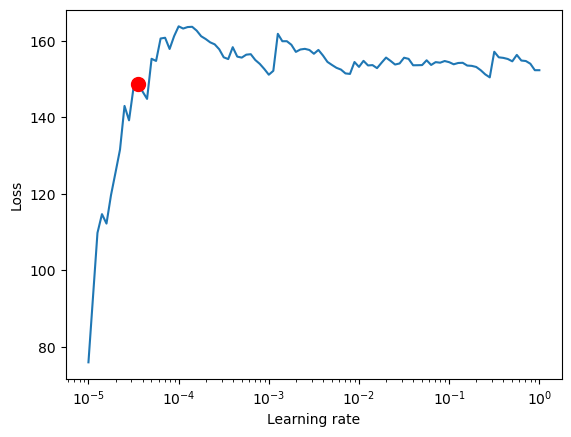

In [29]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=40, rnn_layers=3, loss=MultivariateNormalDistributionLoss()
)

res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [30]:
net.hparams.learning_rate = res.suggestion()

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
net = DeepAR.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    hidden_size=40,
    rnn_layers=3,
    loss=MultivariateNormalDistributionLoss(),
)


In [ ]:

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


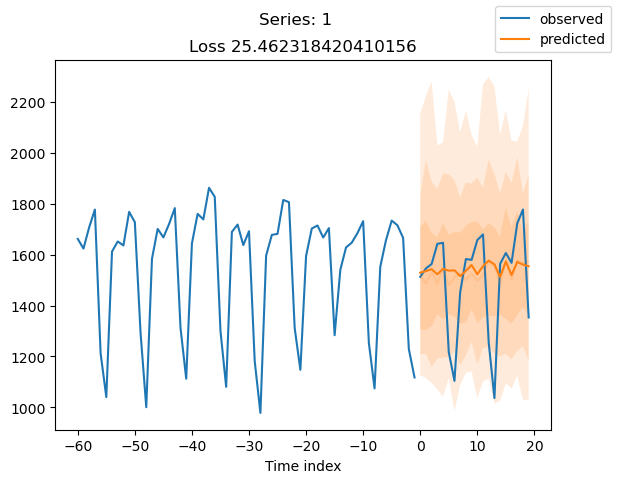

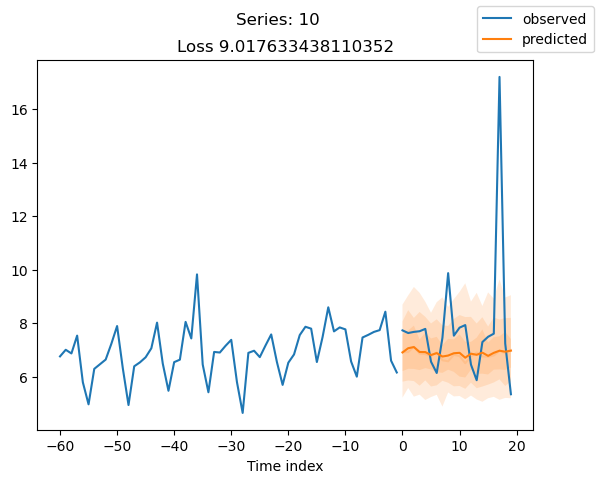

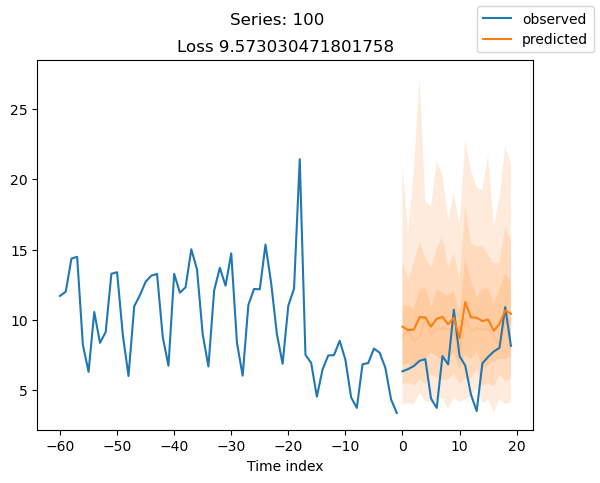

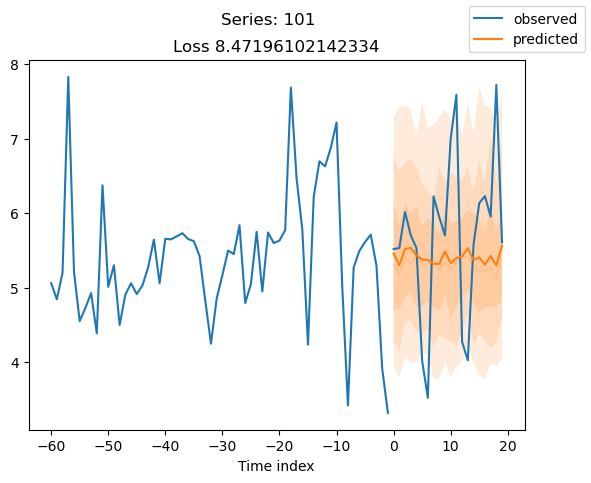

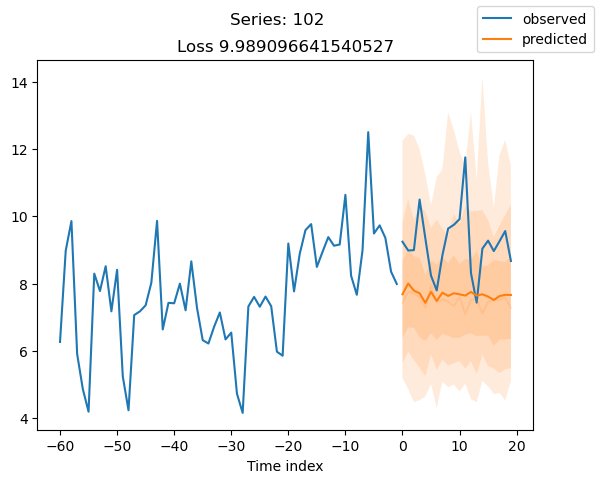

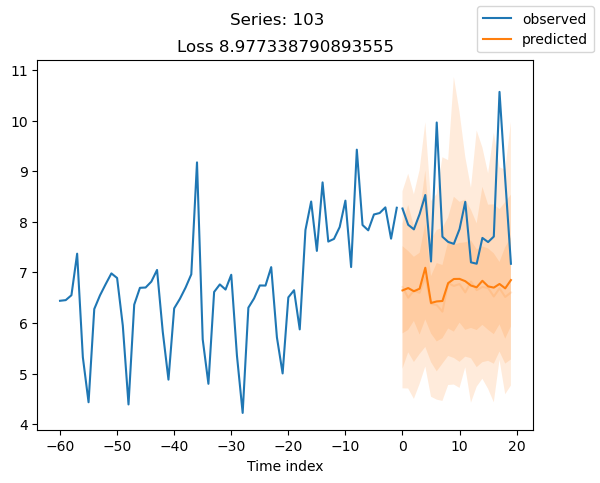

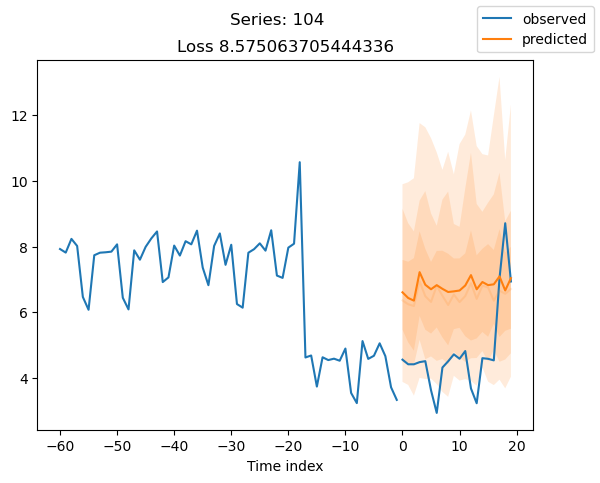

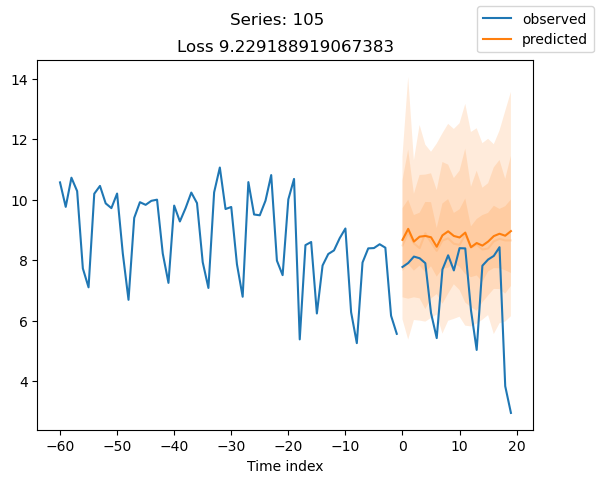

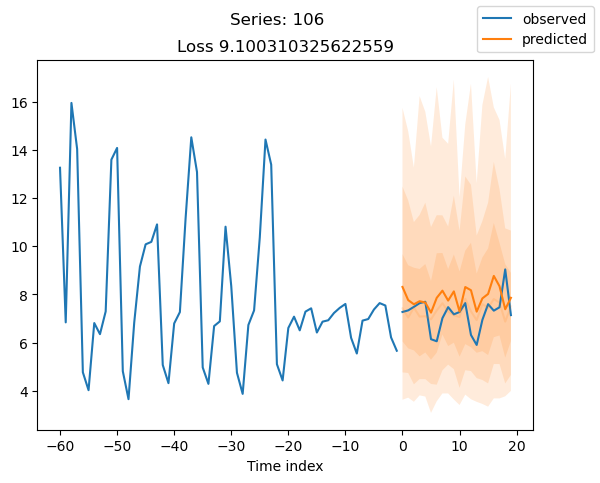

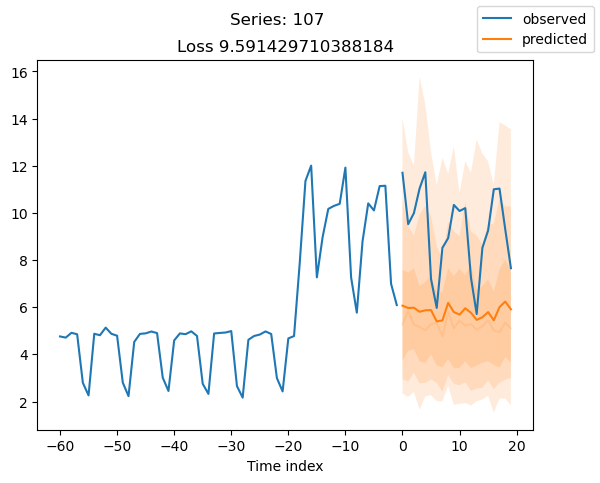

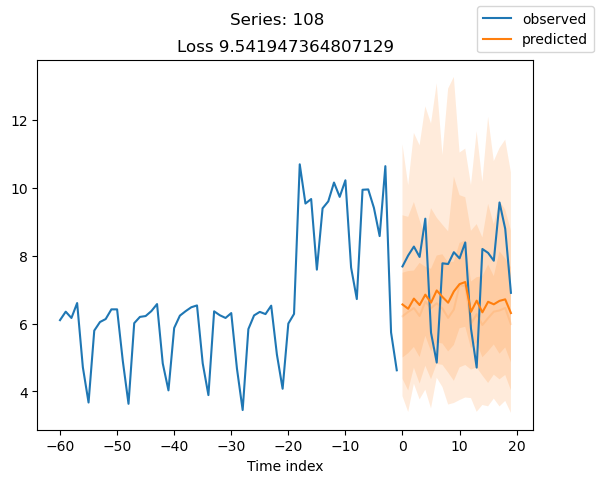

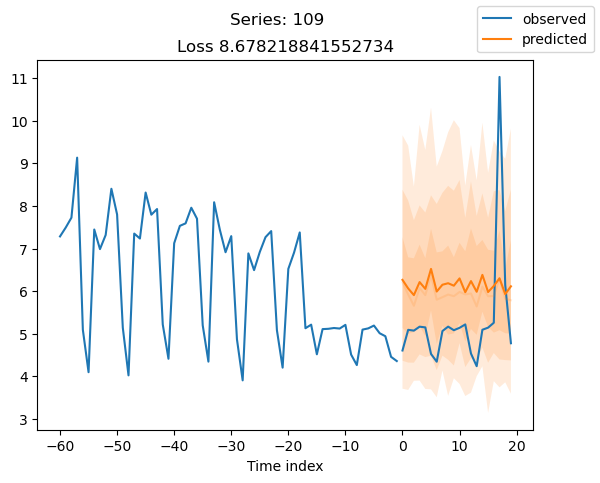

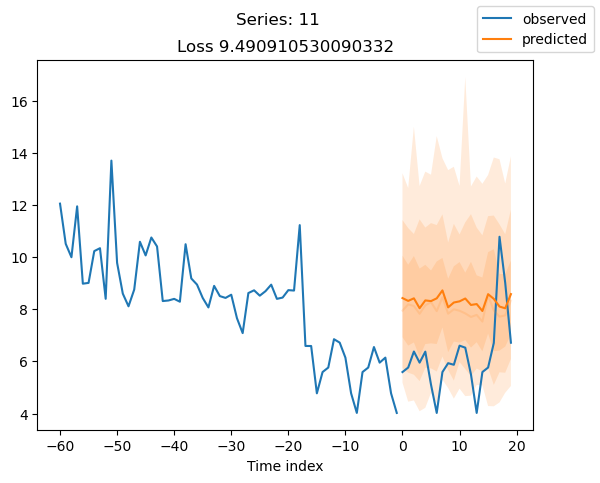

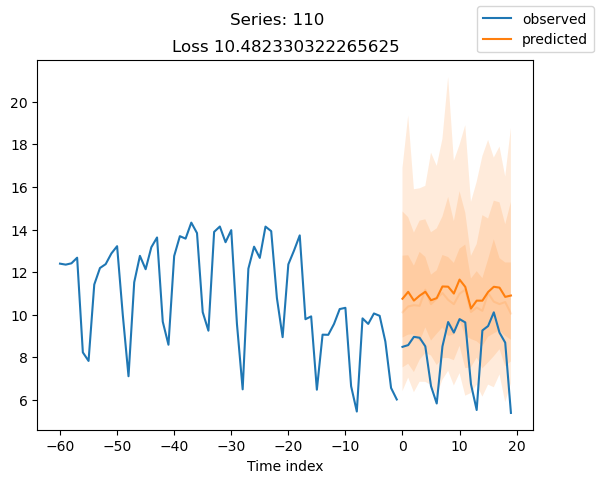

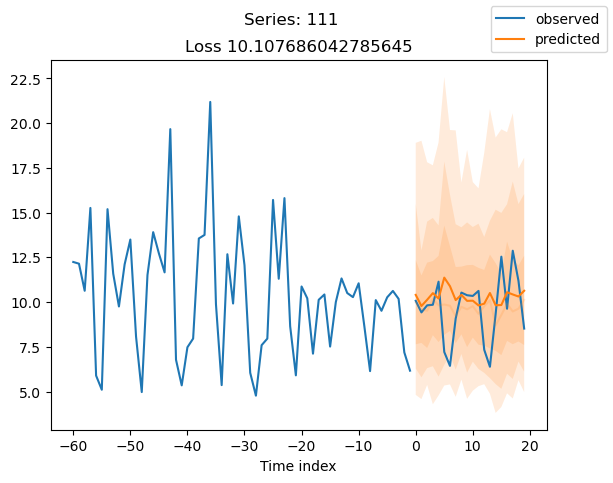

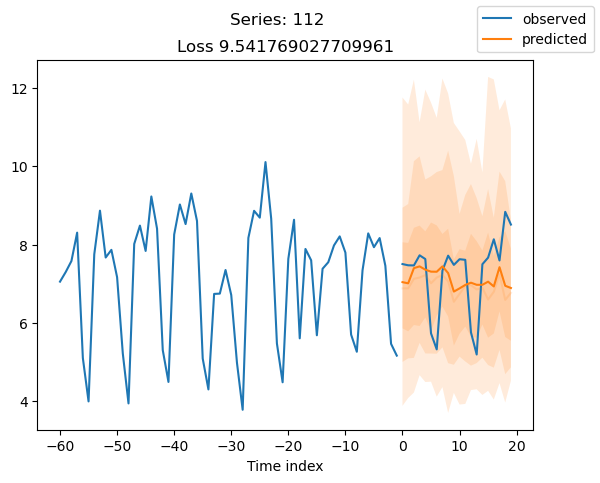

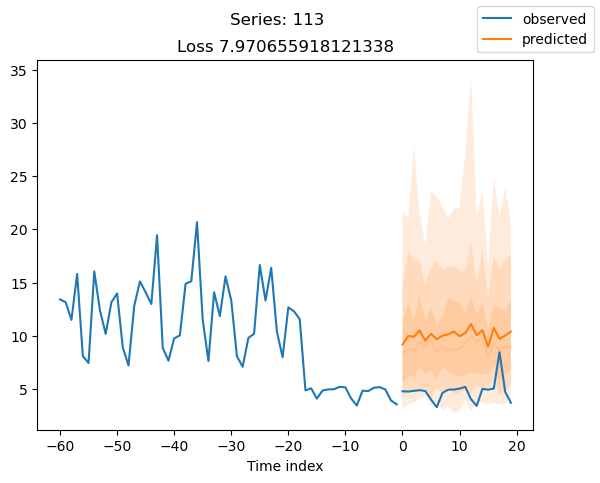

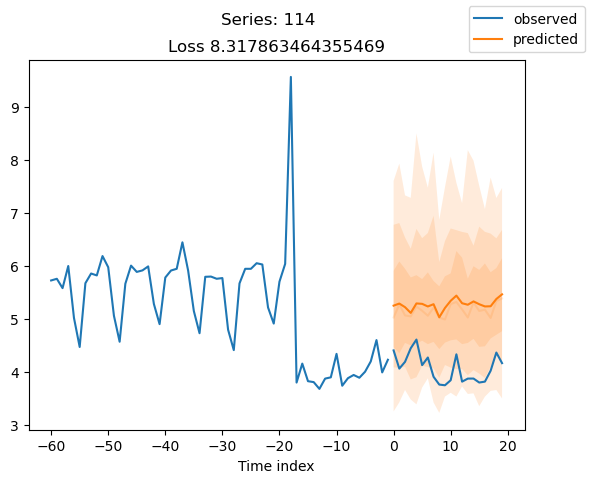

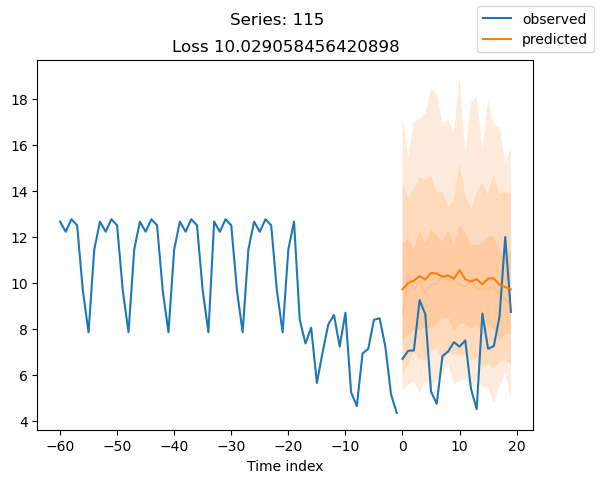

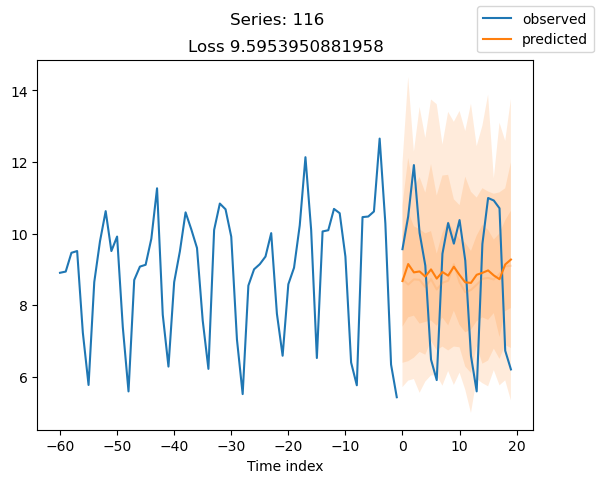

In [16]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

series = validation.x_to_index(x)["series"]
for idx in range(20):  
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")
    plt.savefig(series.iloc[idx])
